### Spectral Energy Distributions

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [52]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from scipy import optimize
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value
from astropy import units

In [22]:
import notebook_utils
import fit_agn_sed
import ezgal_wrapper
import star_formation

/Data/repos/find_agn/star_formation.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/data/miniconda3/envs/find_agn/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/miniconda3/envs/find_agn/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in 

In [15]:
new_model_download = False
if new_model_download:
    !wget -r http://www.baryons.org/ezgal/models/index.html
    # OR for single models:
    # !wget http://www.baryons.org/ezgal/models/$target_model -O $target_loc

In [11]:
bpt_df = pd.read_csv('bpt_df.csv')

The goal is to make a probabilistic estimate the AGN and host SEDs, assuming that most galaxies are truly composite.

If the models are simple, or can be made simple, I can fit them to photometry directly.

If not, I might need to use a template catalog.

In [13]:
seyferts = bpt_df[bpt_df['seyfert']]
starforming = bpt_df[bpt_df['starforming']]

###  What SED do we observe?

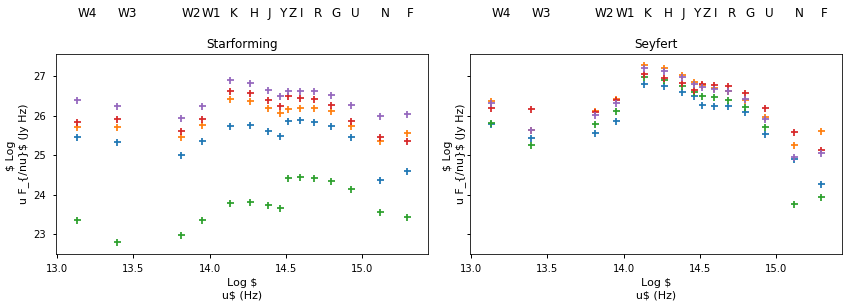

In [20]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4), sharex=True, sharey=True)
for n in range(5):
    starforming_data = notebook_utils.get_spectral_energy(starforming.iloc[n])
    notebook_utils.plot_spectral_energy(starforming_data, ax0)
    
    seyfert_data = notebook_utils.get_spectral_energy(seyferts.iloc[n])
    notebook_utils.plot_spectral_energy(seyfert_data, ax1)
                         
notebook_utils.add_band_labels(starforming_data, ax0)
notebook_utils.add_band_labels(seyfert_data, ax1)
ax0.set_title('Starforming')
ax1.set_title('Seyfert')
fig.tight_layout()

TODO crucially important to add error bars

TODO can ultimately use the optical spectra, not just photometry

### What contribution do AGN make to the SED?

![agn sed](figures/agn_sed_schematic.png)

I'm probing the tail of the accretion disk (optical) and the dusty torus (MIR), overlapping in NIR

Figure in Annual Review, adapted from Harrison, C. M. (2016). Introduction (pp. 1–35). https://doi.org/10.1007/978-3-319-28454-5_1

> it should be noted that the relative contribution of these components can vary dramatically for different types of AGN

>  high-accretion rate AGN that emit most of their energy radiatively (sometimes called “radiatively efficient”, “radiative mode” or, when referring to radio galaxies, “high excitation”; see review in Heckman and Best 2014) and that are radio quiet.4 This thesis does not focus on radiatively-inefficient AGN (sometimes called “low excitation”, “radio mode” or “jet mode”) that emit the majority of their energy mechanically through radio jets 

With BPT, I am selecting radiative mode AGN.

From Best and Heckman 2014 Review:

> {Two AGN types. The first is powered by] efficient conversion of the potential energy of the gas accreted by the SMBH...radiative-mode AGNs. The second category consists of objects that produce relatively little radiation and whose primary energetic output takes the form of the bulk kinetic energy transported in two-sided collimated outflows (jets).

> The ionizing radiation from the disk and corona heats and photoionizes a population of dense gas clouds located on scales of light-days to light-years from the SMBH leading to the production of UV-, optical-, and near-IR-permitted emission lines [Ed: BPT is NOT looking for these lines]

> On larger scales, the SMBH and accretion disk are surrounded by a region of dusty molecular gas...Its inner radius is set by the sublimation temperature of the most refractory dust grains and is hence larger in more luminous AGNs. In this region some of the incident UV/visible photons from the accretion disk and the soft X-rays from the corona are absorbed by the dust, and this absorbed energy emerges as thermal IR emission...As ionizing radiation escapes along the polar axis of the obscuring structure, it photoionizes gas on circumnuclear scales (a few hundred to a few thousand parsecs). This more quiescent and lower-density population of clouds produces UV-, optical-, and IR-forbidden and -permitted emission lines, Doppler-broadened by several hundred kilometers per second, and is hence called the narrow-line region (NLR).

> When observing an AGN from a sight line nearer the equatorial plane of the obscuring structure, this central region is hidden and these are called Type 2 (or obscured) AGNs

This paper has recently done, properly, what I'm hoping to do with SED decomposition: Zhuang, M.-Y., Ho, L. C., & Shangguan, J. (2018). The Infrared Emission and Opening Angle of the Torus in Quasars. Retrieved from http://arxiv.org/abs/1806.03783. They're interested in careful modelling to investigate the torus.

> the bulk of
the mid-IR emission of AGNs actually arises from a polar-extended component, which dominates the energy output in that band, while the near-IR emission still emanates from a classical, small-scale disk-like compo- nent. This discovery radically alters the traditional view of a single torus structure

> We apply these newly developed models to investigate
the physical properties of the torus...We use our recently developed Bayesian Markov Chain Monte Carlo (MCMC) method to decompose the SEDs into their main constituent components, paying special em- phasis on evaluating the performance of the latest spec- tral templates for the AGN torus

Much of the work that they've done is based on:  Shangguan, J., Ho, L. C., & Xie, Y. (2018). On the Gas Content and Efficiency of AGN Feedback in Low-redshift Quasars. The Astrophysical Journal, 854(2), 158. https://doi.org/10.3847/1538-4357/aaa9be

> With a newly developed Bayesian Markov Chain Monte Carlo fitting method, we decompose various overlapping contributions to the integrated spectral energy distribution, including starlight, warm dust from the torus, and cooler dust on galaxy scales. 

Both papers use pretty much the same models for the various AGN and host components...

**CLUMPY**

> For the dust torus emission, we incorporate the templates generated by the radiative transfer model CLUMPY (Nenkova et al. 2008a, 2008b).

[CLUMPY](https://www.clumpy.org/) provides an extensive library of templates for dusty torus emission. 

> The CLUMPY model has seven free parameters: the optical depth of the individual cloud τV, the power-law index q of the cloud radial distribution, the ratio Y of outer and inner radii of the dust torus,14 the average number of clouds on the equatorial ray N0, the standard deviation σ of the Gaussian distribution of the number of clouds in the polar direction, the observer’s viewing angle i from the torus axis, and the luminosity L normalization factor. 

**BB**

Shangguan and others add a hot blackbody to the MIR to get a good fit - see Shangguan equation 1.

**EzGal**

> The stellar emission is represented by a simple stellar population model from **Bruzual & Charlot (2003, hereafter BC03)** with a Chabrier (2003) stellar IMF. We use the Python package **EzGal (Mancone & Gonzalez 2012)** to generate the template spectra. 

**DL07**

> The galactic dust emission is described by the widely used
DL07 model. The model is based on the dust composition and size distribution observed in the Milky Way (MW)...DL07 [provide](https://www.astro.princeton.edu/~draine/dust/irem.html) the precalculated pq U,
n ()() 0 PAH min and pν?(qPAH, Umin, Umax, α) as model
templates.

> By studying the SEDs of normal star-forming galaxies, Draine et al. (2007) found that, for all situations, we can fix α?=?2 and Umax?=?106. We adopt this simplification

I do not include a radio synchrotron component.

The templates provide the forward model: given some parameters, what SED (components) do I get. With templates, this step is completely deterministic - they're simply a grid of pre-calculated values.

In [16]:
sample_galaxy = bpt_df.iloc[0]

In [ ]:
ref_exponential = lambda x: star_formation.exponential_sfh(x, tau=1.)

In [24]:
target_model = '{}_{}_z_{}_{}.model'.format('bc03', 'ssp', '0.02', 'salp')
model_download_loc = 'catalogs/' + target_model
model = ezgal_wrapper.get_model(model_download_loc, ref_exponential)
formation_z = 3.0
# current_z = sample_galaxy['z'] TODO add
current_z = 0.05
mass = sample_galaxy['ELPETRO_MASS']
fake_galaxy = ezgal_wrapper.get_fake_galaxy(model, formation_z, current_z, mass)

catalogs/bc03_ssp_z_0.02_salp.model


/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadrature.py:326: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadrature.py:328: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadrature.py:329: RuntimeWarning: invalid value encountered in add
  y[slice2]*(2-h0divh1))
/data/repos/find_agn/easyGalaxy/ezgal/cosmology.py:185: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)


In [25]:
fake_data = notebook_utils.get_spectral_energy(fake_galaxy)

In [36]:
model_continuum = ezgal_wrapper.get_normalised_model_continuum(model, fake_galaxy)

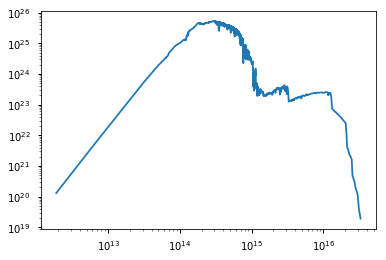

In [37]:
plt.loglog(model_continuum['frequency'], model_continuum['energy'])

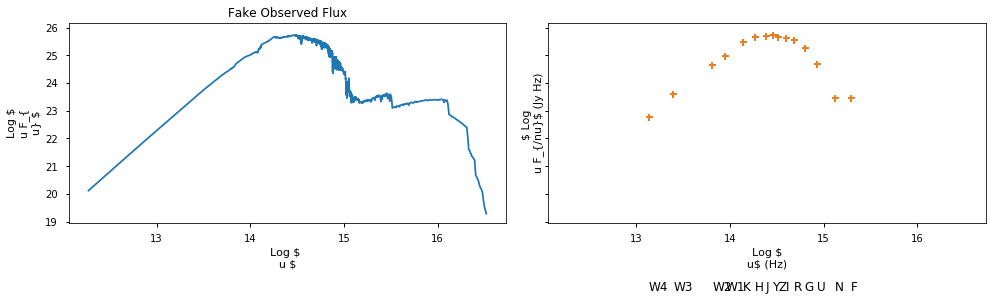

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharex=True, sharey=True)
axes[0].plot(np.log10(model_continuum['frequency']), np.log10(model_continuum['energy']))  # shifted way down for some reason
axes[0].set_title('Fake SED')
axes[0].set_xlabel('Log $ \nu $')
axes[0].set_ylabel('Log $\nu F_{\nu} $')

axes[1].scatter(np.log10(fake_data['frequency']), np.log10(fake_data['energy']), marker='+')
axes[0].set_title('Fake Observed Flux')
notebook_utils.plot_spectral_energy(fake_data, ax=axes[1])

notebook_utils.add_band_labels(fake_data, ax=axes[1], y=16.5)

fig.tight_layout()

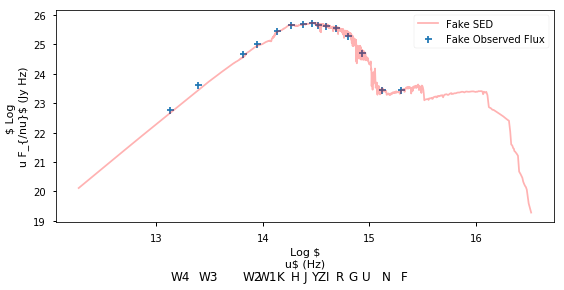

In [39]:
fig, ax = plt.subplots(figsize=(8, 4), sharex=True, sharey=True)

ax.plot(np.log10(model_continuum['frequency']),  np.log10(model_continuum['energy']), 'r', alpha=0.3)  # shifted way down for some reason
notebook_utils.plot_spectral_energy(fake_data, ax=ax)

ax.legend(['Fake SED', 'Fake Observed Flux'])
notebook_utils.add_band_labels(fake_data, ax=ax, y=17)
fig.tight_layout()

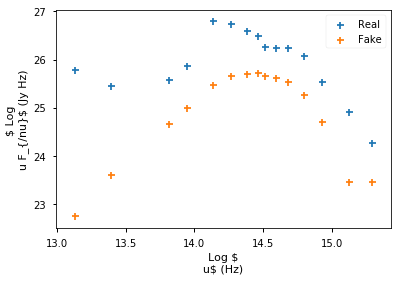

In [40]:
real_data = notebook_utils.get_spectral_energy(seyferts.iloc[0])

fig, ax = plt.subplots()
notebook_utils.plot_spectral_energy(real_data, ax)
notebook_utils.plot_spectral_energy(fake_data, ax)
ax.legend(['Real', 'Fake'])

gaussian_scale_a: 0.3821934434704673
gaussian_skew_a: 1.4424939475724414
shift_for_gaussian_a: 5.610172578050789
gaussian_scale_b: 0.2894916400026148
gaussian_skew_b: 1.0559615197987908
shift_for_gaussian_b: 5.026627159817576


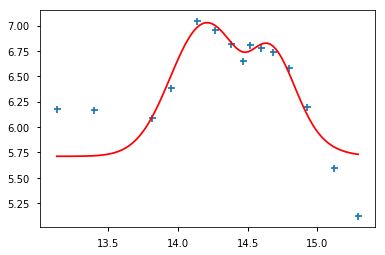

In [41]:
# data to fit
# sed = notebook_utils.get_spectral_energy(starforming.iloc[0])
sed = notebook_utils.get_spectral_energy(seyferts.iloc[3])

freq = np.log10(sed['frequency'])
energy = np.log10(sed['energy']) - 20

best_fit = fit_agn_sed.fit_agn_model_to_spectral_data(freq, energy)

shift_for_host: -8.273830974658996


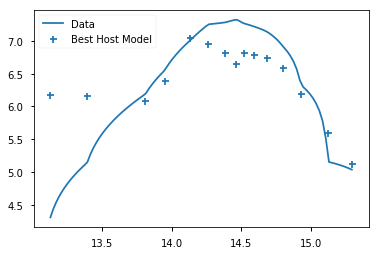

In [42]:
# data to fit
# sed = notebook_utils.get_spectral_energy(starforming.iloc[0])
sed = notebook_utils.get_spectral_energy(seyferts.iloc[3])

log_freq = np.log10(sed['frequency'])
log_energy = np.log10(sed['energy']) - 20

_ = fit_agn_sed.fit_host_model_to_spectral_data(log_freq, log_energy)

gaussian_scale_a: 0.3822534885747911
gaussian_skew_a: 1.442681329909489
shift_for_gaussian_a: 5.610274510036825
gaussian_scale_b: 0.28949559684041243
gaussian_skew_b: 1.0569520524879976
shift_for_gaussian_b: 5.026108379732726
shift_for_host: -12.316004751387803


/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1600.
  warnings.warn(errors[info][0], RuntimeWarning)


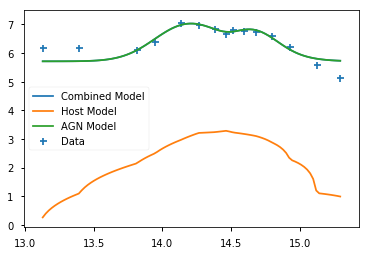

In [43]:
# data to fit
# sed = notebook_utils.get_spectral_energy(starforming.iloc[0])
sed = notebook_utils.get_spectral_energy(seyferts.iloc[3])

log_freq = np.log10(sed['frequency'])
log_energy = np.log10(sed['energy']) - 20  # keep the energy numbers reasonable

_ = fit_agn_sed.fit_composite_model_to_spectral_data(log_freq, log_energy)


Mullaney, J. R., Alexander, D. M., Goulding, A. D., & Hickox, R. C. (2011). Defining the intrinsic AGN infrared spectral energy distribution and measuring its contribution to the infrared output of composite galaxies. Monthly Notices of the Royal Astronomical Society, 414(2), 1082–1110. https://doi.org/10.1111/j.1365-2966.2011.18448.x

> Looked at 11 moderate luminosity $L_{2−10 keV} ∼ 10^{42}–10^{44} erg s^{−1} $ AGN with minimal IR host contamination

> Between 6–100 µm...the average infrared SED of typical AGNs is best described as a broken power law at ?40µm that falls steeply at ?40 µm (i.e. at far-infrared wavelengths).

> to identify a sample of galaxies whose infrared out-
put is dominated by a moderate-luminosity AGN, we cross-match the Swift-BAT samplewith the archive of low-resolution spectra ob- tained by the infrared spectrograph (hereafter IRS) on board Spitzer...we quantify the con- tribution of the host galaxy to theseMIRspectra using the equivalent
widths of the 11.25-µm PAH feature

Sadly, this requires IR spectroscopy - which is not available to me?

> strongly AGN dominated systems have EW PAHλ11.25 < 0.03µm, corresponding to a <10 per cent host-galaxy contribution at 19 µm(see

> infrared spectra...dominated by a featureless AGN continuum
                                                                                                                               
                                                                                                                               > ∼6–20 µm. At these wavelengths, all the 25 AGN- dominated SEDs show clear evidence of a continuous, underlying
power-law continuum that is thought to be produced by multiple dust components spanning a range of temperatures (e.g. Buchanan et al. 2006). The spectral indices of the underlying AGN power-law continua
span the range 0.7 ≤ α1 ≤ 2.7 (mean, α1 = 1.6)

>In at least 20 of the 25 AGN-dominated MIR spectra there is a definite break in the power-law continuum at 15–20 µm; the
mean break position is at ∼19 µm. In previous studies this has been attributed to a dominatingwarm (i.e.∼170 K) dust component that is heated by the AGN...where we see a break in the continuum power law, the AGN SED longward of λBrk has a lower spectral
index (i.e. power-law index, 0 ≤ α2 ≤ 1.5, mean = 0.7

I should put the AGN models aside for now and just like at how much star formation can be going on.

I should review the Ellison 2016 paper that gets Lir from Ellison NN and aim to replicate the plot of star formation (from Lir) vs num galaxies hist, for different AGN selection - but in my case, for plausible AGN LOIII as well. Slider!

I should use an EZGAL BC03 or derivative model (M is wrong), with an old (>5Gyr) population and a current burst. BPT measures current SF, remember.


I need a link between L[OIII] and star formation. There are empirical scaling relations for star formation -> L[OIIII], and there might also be extractable lines from the SED models.

For later, it might be really interesting to look at independent SF probes. Look at ALFAFA - radio survey of HI in many sloan galaxies.

### EZGAL models of old population + new bursty population

In [ ]:
sample_galaxy = starforming.iloc[0]

In [46]:
ezgal_model_dir = 'models/ezgal_models'

reference_model_loc = 'test_figures/bc03_ssp_z_0.02_salp.model'  # ssp will be overridden

model_loc = reference_model_loc
# model_loc = os.path.join(ezgal_model_dir, '{}_{}_z_{}_{}.fits'.format(modelset, sfh, met, imf))

Define an arbitrary star formation history: See [here](http://www.baryons.org/ezgal/manual/modifying_models.html)

In [73]:
def formation_redshift_for_fixed_age(current_z, current_galaxy_age):
    universe_age_at_current_redshift = cosmo.age(current_z)
    assert universe_age_at_current_redshift > 12 * units.Gyr
    universe_age_at_formation_redshift = universe_age_at_current_redshift - current_galaxy_age
    assert universe_age_at_formation_redshift < 6 * units.Gyr
    formation_z = z_at_value(cosmo.age, universe_age_at_formation_redshift)
    assert formation_z > 1
    return formation_z

In [76]:
# To minimise saved model grid dimensions, 
# make all galaxies the same age: 8 Gyr from formation
current_galaxy_age = 8 * units.Gyr
current_z = 0.05  # defined to be here, very small error introduced
formation_z = formation_redshift_for_fixed_age(current_z, current_galaxy_age)

In [77]:
first_duration = 1.  # Gyr
second_duration = .5  # Gyr
dual_burst = lambda x: starformation_history.dual_burst_sfh(
        x,
        current_z=current_z,
        formation_z=formation_z, 
        first_duration=first_duration, 
        second_duration=second_duration, 
        )

In [78]:
model = ezgal_wrapper.get_model(model_loc, dual_burst)  # 15 mins to calculate

test_figures/bc03_ssp_z_0.02_salp.model


/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadrature.py:326: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/scipy/integrate/quadrature.py:328: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/data/miniconda3/envs/find_agn/lib/python3.6/site-packag

#### Save outputs from reference model in lookup table

In [79]:
mass = 1.  # do not rescale, leave as 1 Msun stellar population
# TODO refactor magnitude mass rescaling as separate notebook_utils method
ezgal_wrapper.save_model(model, save_dir, formation_z, current_z, mass)

/Data/repos/find_agn/star_formation.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/data/miniconda3/envs/find_agn/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/miniconda3/envs/find_agn/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in 

NameError: name 'save_dir' is not defined

#### Visualise to confirm

### Fit model to real SED to derive max and min star formation

### Convert max and min star formation to L[OIII]/Ha, either empirically or (ideally) direct from model

In [ ]:
import json

In [ ]:
sed_loc = 'fake_sed.txt'
with open(sed_loc, 'r') as f:
    sed = json.load(f)